## Loading a model

In [64]:
import jax
import matplotlib.pyplot as plt
import numpy as np
import pprint
import xarray

!git clone https://github.com/mylrcd/neuralgcmPFE.git
%pip install -e neuralgcmPFE

from neuralgcmPFE import neuralgcm

import warnings
warnings.filterwarnings('ignore')

4101.51s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


fatal: destination path 'neuralgcmPFE' already exists and is not an empty directory.


4106.72s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Obtaining file:///array/shared/home/mricard/NeuralGCM/quickstart/neuralgcmPFE
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for neuralgcm (pyproject.toml) ... done
  Created wheel for neuralgcm: filename=neuralgcm-1.0.0-0.editable-py3-none-any.whl size=11441 sha256=393f0875ff518a4b3250ca6e0944de257fe6df79c362b7219c5af2bf7f108f0c
  Stored in directory: /tmp/pip-ephem-wheel-cache-d9qtgb0h/wheels/82/a4/36/f5e51da337f10d87d4ce2376f743c565d82ae5369d1d9cb14b
Successfully built neuralgcm
  Attempting uninstall: neuralgcm
    Found existing installation: neuralgcm 1.0.0
    Uninstalling neuralgcm-1.0.0:
      Successfully uninstalled neuralgcm-1.0.0
Note: you may need to restart the kernel to use updated packages.


In [65]:
from neuralgcmPFE.neuralgcm import demo

checkpoint = neuralgcm.demo.load_checkpoint_tl63_stochastic()
model = neuralgcm.PressureLevelModel.from_checkpoint(checkpoint)

In [66]:
ds = neuralgcm.demo.load_data(model.data_coords)
ds_init = ds.isel(time=0)
inputs, forcings = model.data_from_xarray(ds_init)

## Encoding & decoding data

In [67]:
encoded = model.encode(inputs, forcings, jax.random.key(0))

In [68]:
inputs_keys = list(inputs.keys())
forcings_keys = list(forcings.keys())

inputs_keys, forcings_keys

(['geopotential',
  'specific_humidity',
  'temperature',
  'u_component_of_wind',
  'v_component_of_wind',
  'specific_cloud_ice_water_content',
  'specific_cloud_liquid_water_content',
  'sim_time'],
 ['sea_ice_cover', 'sea_surface_temperature', 'sim_time'])

In [69]:
decoded = model.decode(encoded, forcings)

In [70]:
abs(inputs['temperature'][-1] - decoded['temperature'][-1]).mean()

Array(1.2640814, dtype=float32)

## Advancing in time

In [71]:
assert model.timestep == np.timedelta64(1, 'h')
advanced = model.advance(encoded, forcings)

In [72]:
all_forcings = model.forcings_from_xarray(ds)
advanced, outputs = model.unroll(encoded, all_forcings, steps=4, timedelta=np.timedelta64(1, 'h'))

## JAX transformations (jit, grad, etc)

In [73]:
import jax
import optax

@jax.jit
def compute_loss(model, inputs, forcings, rng):
    encoded = model.encode(inputs, forcings, rng_key=rng)
    restored = model.decode(encoded, forcings)
    return abs(inputs['temperature'] - restored['temperature']).mean()

In [74]:
compute_loss(model, inputs, forcings, jax.random.key(0))

Array(6.225657, dtype=float32)

In [75]:
optimizer = optax.adam(1e-3)
opt_model = model
opt_state = optimizer.init(model)
for i in range(5):
    loss, grads = jax.value_and_grad(compute_loss)(
        opt_model, inputs, forcings, jax.random.key(0)
    )
    updates, opt_state = optimizer.update(grads, opt_state)
    opt_model = optax.apply_updates(opt_model, updates)
    print(f'{i=}, {loss=}')

i=0, loss=Array(6.225657, dtype=float32)
i=1, loss=Array(4.670489, dtype=float32)
i=2, loss=Array(3.8556738, dtype=float32)
i=3, loss=Array(3.5485837, dtype=float32)
i=4, loss=Array(3.433563, dtype=float32)


In [76]:
pprint.pprint(jax.tree.map(np.shape, encoded))

ModelState(state=StateWithTime(vorticity=(32, 128, 65),
                               divergence=(32, 128, 65),
                               temperature_variation=(32, 128, 65),
                               log_surface_pressure=(1, 128, 65),
                               sim_time=(),
                               tracers={'specific_cloud_ice_water_content': (32,
                                                                             128,
                                                                             65),
                                        'specific_cloud_liquid_water_content': (32,
                                                                                128,
                                                                                65),
                                        'specific_humidity': (32, 128, 65)}),
           memory=None,
           diagnostics={},
           randomness=RandomnessState(core=(10, 128, 65),
                       

In [77]:
from dinosaur import spherical_harmonic

nodal_vorticity = model.model_coords.horizontal.to_nodal(encoded.state.vorticity)
nodal_divergence = model.model_coords.horizontal.to_nodal(encoded.state.divergence)

nodal_u_wind, nodal_v_wind = spherical_harmonic.vor_div_to_uv_nodal(
    model.model_coords.horizontal,
    encoded.state.vorticity,
    encoded.state.divergence,
)

encoded_ds = model.data_to_xarray(
    {
        'vorticity': model.from_nondim_units(nodal_vorticity, '1/s'),
        'divergence': model.from_nondim_units(nodal_divergence, '1/s'),
        'u_wind': model.from_nondim_units(nodal_u_wind, 'm/s'),
        'v_wind': model.from_nondim_units(nodal_v_wind, 'm/s'),
    },
    times=None,
    decoded=False,
)

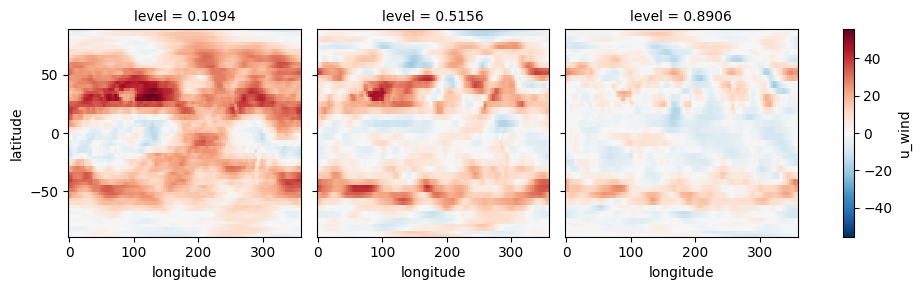

In [78]:
encoded_ds.u_wind.sel(level=[0.1, 0.5, 0.9], method='nearest').plot.imshow(
    x='longitude', y='latitude', col='level',
);

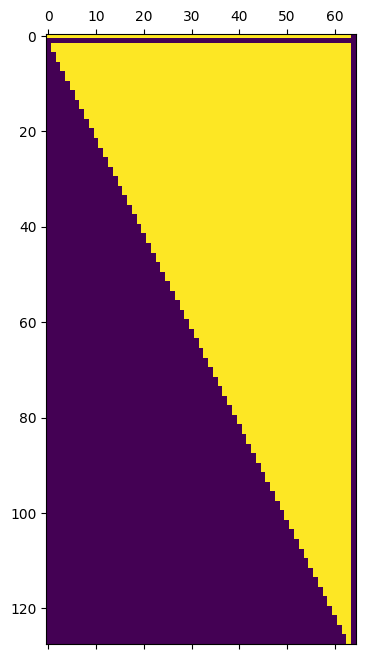

In [79]:
plt.matshow(encoded.state.temperature_variation[0] != 0);

In [80]:
model.model_coords.horizontal.mask

array([[ True,  True,  True, ...,  True,  True,  True],
       [False, False, False, ..., False, False, False],
       [False,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ..., False,  True,  True],
       [False, False, False, ..., False,  True,  True]])

## Random noise

In [81]:
encoded = model.encode(inputs, forcings, jax.random.key(0))
encoded2 = model.encode(inputs, forcings, jax.random.key(1))

In [82]:
# slightly different average temperatures
encoded.state.temperature_variation.mean(), encoded2.state.temperature_variation.mean()

(Array(-0.00401366, dtype=float32), Array(-0.00391874, dtype=float32))

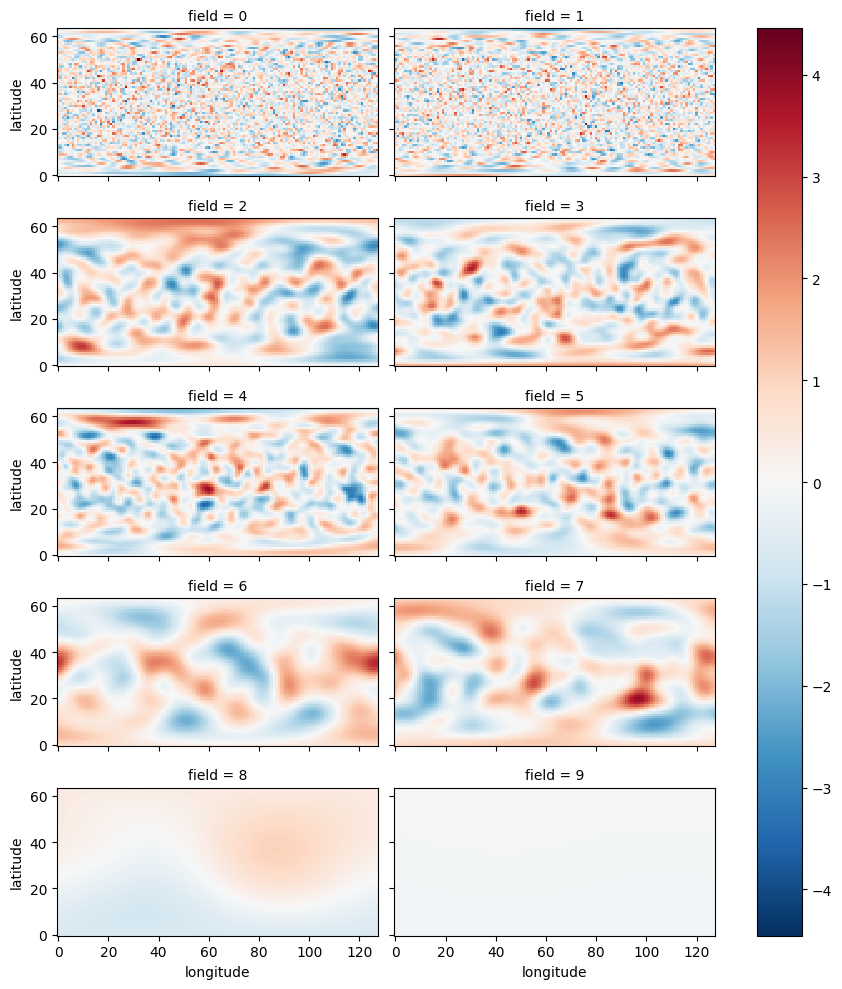

In [83]:
xarray.DataArray(
    encoded.randomness.nodal_value,
    dims=['field', 'longitude', 'latitude'],
).plot(x='longitude', y='latitude', col='field', col_wrap=2, aspect=2, size=2);

In [84]:
encoded_with_new_rng = encoded.replace(randomness=encoded.randomness.replace(prng_key=jax.random.key(123)))

In [85]:
advanced_with_new_rng = model.advance(encoded_with_new_rng, forcings)

In [86]:
advanced.state.temperature_variation.mean(), advanced_with_new_rng.state.temperature_variation.mean()

(Array(-0.00416083, dtype=float32), Array(-0.00420047, dtype=float32))